Take Home Assignment 3

INDEX NO: EGT/20/572                                                                           || NAME:N.THENUSHAN

3.0 Install any dependencies if needed 


In [ ]:
!pip install supervision
!pip install ultralytics

In [11]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time
import supervision as sv
from transformers import pipeline
from supervision.utils.video import get_video_frames_generator, VideoSink
from supervision.detection.core import Detections

3.1.1 Draw the segmentation mask of the largest car: Use ultralytics library only

In [12]:
img = cv2.imread("demo5_images/cars1.jpg")

In [ ]:
# Run a segmentation model on the image 

# Iterate through the boxes in the results object 
    # For each box , obtain the coordinates of the box, evaluate area
    # Find out the index of the box with the largest area

# Draw the mask of the box with the largest area. 


0: 416x640 14 cars, 112.0ms
Speed: 4.3ms preprocess, 112.0ms inference, 8.9ms postprocess per image at shape (1, 3, 416, 640)
Mask values:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


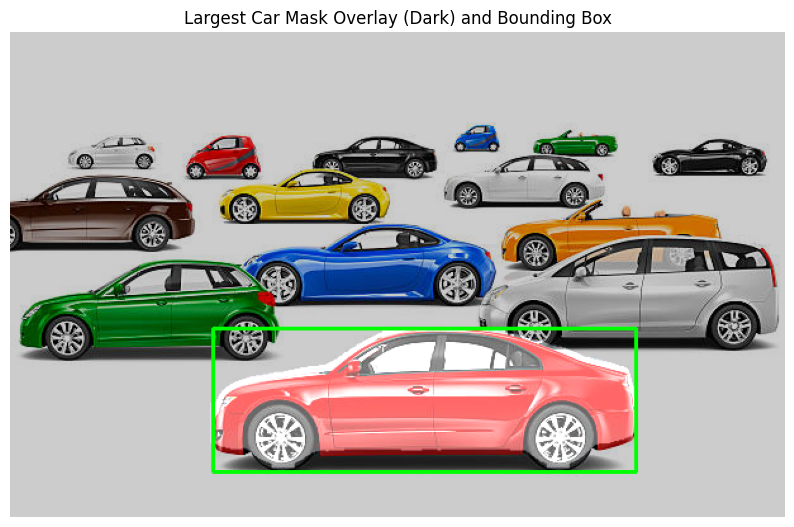

In [13]:

# Load the YOLO segmentation model 
model = YOLO('yolo11n-seg.pt')

# Run inference
results = model(img)

# Initialize variables to track the largest mask
largest_area = 0
largest_mask = None
largest_box = None

# Access the segmentation masks and bounding boxes
for i, box in enumerate(results[0].boxes.xyxy):  # Iterate through bounding boxes
    # Get coordinates and calculate the area
    x1, y1, x2, y2 = map(int, box)
    area = (x2 - x1) * (y2 - y1)
    
    # Compare with the largest area
    if area > largest_area:
        largest_area = area
        largest_mask = results[0].masks.data[i]
        largest_box = (x1, y1, x2, y2)

# Draw the segmentation mask of the largest box
if largest_mask is not None:
    # Convert the mask to uint8 format
    mask = (largest_mask.cpu().numpy() * 255).astype(np.uint8)
    
    # Print all mask values (raw pixel values)
    print("Mask values:")
    print(mask)
    
    # Resize the mask to match the original image dimensions
    mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]))
    
    # Apply a darker color map to the resized mask
    mask_color = cv2.applyColorMap(mask_resized, cv2.COLORMAP_BONE)
    
    # Ensure both `img` and `mask_color` have the same number of channels
    if len(mask_color.shape) == 2:
        mask_color = cv2.cvtColor(mask_color, cv2.COLOR_GRAY2BGR)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # Blend the image and the mask
    img_with_mask = cv2.addWeighted(img, 0.8, mask_color, 0.4, 0)

    # Draw the bounding box around the largest object
    x1, y1, x2, y2 = largest_box
    cv2.rectangle(img_with_mask, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green bounding box

    # Convert BGR image to RGB for Matplotlib display
    img_with_mask_rgb = cv2.cvtColor(img_with_mask, cv2.COLOR_BGR2RGB)
    
    # Display the result using matplotlib so it appears below the cell
    plt.figure(figsize=(10, 10))
    plt.imshow(img_with_mask_rgb)
    plt.title("Largest Car Mask Overlay (Dark) and Bounding Box")
    plt.axis("off")
    plt.show()
else:
    print("No masks found in the image.")


3.1.2 Draw the segmentation mask of the largest car : Use ultralytics + supervision libraries

In [ ]:
# Run a segmentation model on the image using ultralytics libraries & a model of your choice

# Transfer ultralytics results to supervision

# Iterate through the masks & find the largest

# Display the largest mask


0: 416x640 14 cars, 116.1ms
Speed: 3.7ms preprocess, 116.1ms inference, 9.6ms postprocess per image at shape (1, 3, 416, 640)
Method from_yolov8 not found in supervision, skipping conversion: type object 'Detections' has no attribute 'from_yolov8'


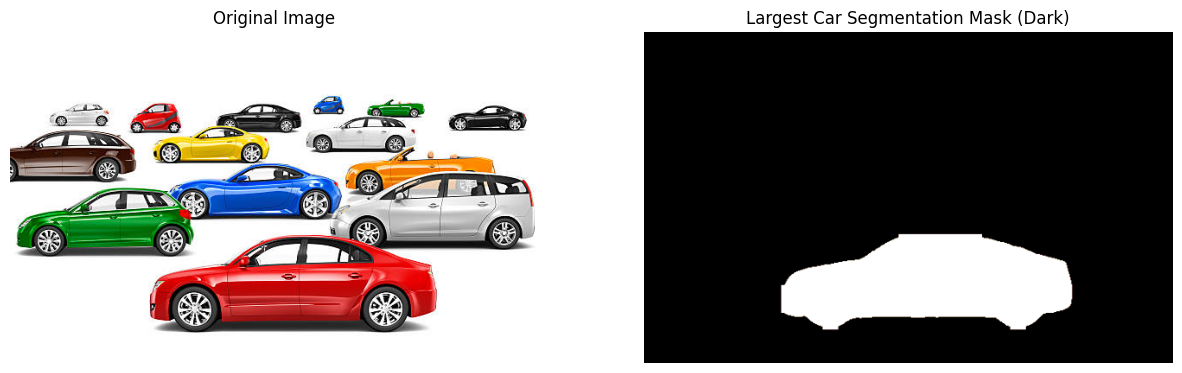

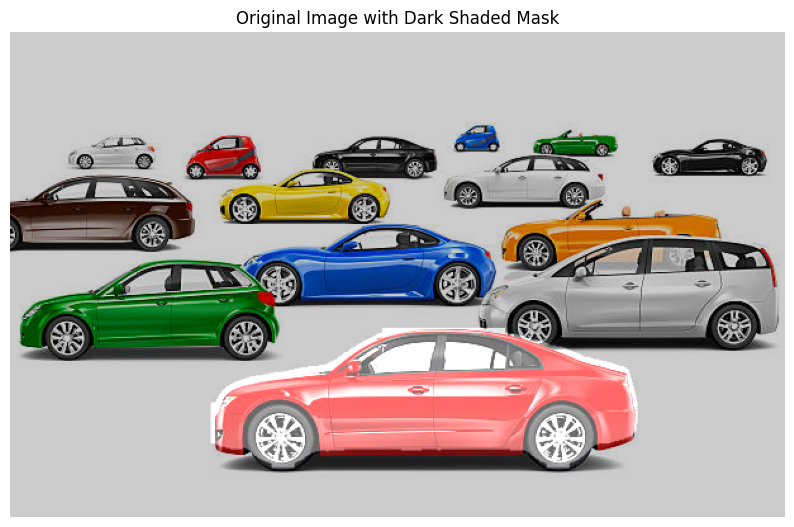

In [5]:
# Load the YOLO segmentation model
model = YOLO('yolo11n-seg.pt')

# Read the input image
img = cv2.imread("demo5_images/cars1.jpg")
if img is None:
    raise FileNotFoundError("Input image not found. Check the path.")

# Run inference using the ultralytics segmentation model
results = model(img)

# Transfer ultralytics results to supervision 
try:
    detections = sv.Detections.from_yolov8(results[0])
    print("Converted ultralytics results to supervision detections.")
except AttributeError as e:
    print("Method from_yolov8 not found in supervision, skipping conversion:", e)

# Initialize variables to track the largest mask
largest_area = 0
largest_mask = None

# Iterate through the segmentation masks (and bounding boxes)
for i, box in enumerate(results[0].boxes.xyxy):
    # Get coordinates and calculate the area of the detection box
    x1, y1, x2, y2 = map(int, box)
    area = (x2 - x1) * (y2 - y1)
    
    # Compare with the largest area and update largest_mask if greater
    if area > largest_area:
        largest_area = area
        largest_mask = results[0].masks.data[i]

# Draw and display the segmentation mask of the largest box
if largest_mask is not None:
    # Convert the mask to a uint8 image (0-255)
    mask = (largest_mask.cpu().numpy() * 255).astype(np.uint8)
    
    # Resize the mask to match the original image dimensions
    mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]))
    
    # Apply a darker color map to the resized mask
    mask_color = cv2.applyColorMap(mask_resized, cv2.COLORMAP_BONE)
    
    # Ensure both `img` and `mask_color` have the same number of channels
    if len(mask_color.shape) == 2:
        mask_color = cv2.cvtColor(mask_color, cv2.COLOR_GRAY2BGR)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # Blend the original image and the mask (dark-shaded effect)
    img_with_mask = cv2.addWeighted(img, 0.8, mask_color, 0.4, 0)

    # Display the original image and the mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    # Display the original image
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # Display the largest mask
    axes[1].imshow(mask_color)
    axes[1].set_title("Largest Car Segmentation Mask (Dark)")
    axes[1].axis("off")
    
    # Show the blended image with the dark-shaded mask
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_with_mask, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Dark Shaded Mask")
    plt.axis("off")
    plt.show()

else:
    print("No masks found in the image.")


3.2 Estimate distance to centroid of chair 


0: 384x640 1 chair, 99.1ms
Speed: 2.8ms preprocess, 99.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Chair centroid: (352, 181)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


Depth at centroid: 146


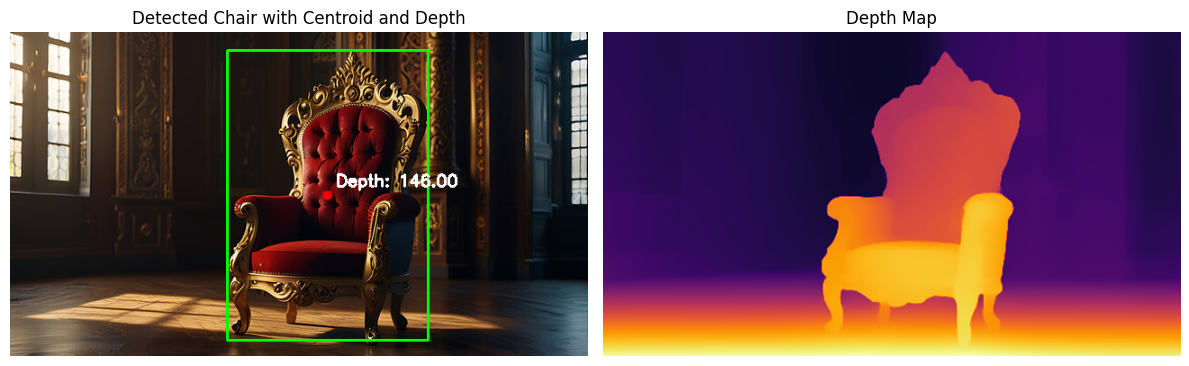

In [6]:
# Detect the chair in the image  - A detection model of your choice can be used

# Calculate the centroid of the chair - Access box coordinates from the detection model and calculate the centroid

# Obtain the depth map - Depth Anything V2 can be used 

# Query the value of the depth map at the centroid's location


# Read the chair image
img_path = "demo5_images/kingChair.jpg"
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image '{img_path}' not found in demo5_images folder.")

# 1. Detect the chair using YOLOv8
model_det = YOLO('yolov8n.pt')  # Load YOLO model
results_det = model_det(img)

# Initialize variable to hold the chair bounding box
chair_box = None

# Iterate over detections to find a chair
for r in results_det:
    for i, box in enumerate(r.boxes.xyxy.cpu().numpy()):
        class_id = int(r.boxes.cls[i].item())
        label = r.names[class_id]
        # Check for 'chair' label (case-insensitive)
        if label.lower() == "chair":
            chair_box = list(map(int, box))
            break
    if chair_box is not None:
        break

if chair_box is None:
    print("No chair detected in the image.")
else:
    # 2. Calculate the centroid of the chair
    x1, y1, x2, y2 = chair_box
    centroid = ((x1 + x2) // 2, (y1 + y2) // 2)
    print("Chair centroid:", centroid)

    # 3. Obtain the depth map using Depth Anything V2
    try:
        pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
        image_pil = Image.open(img_path)
        result = pipe(image_pil)
        depth_map = np.array(result["depth"])
    except Exception as e:
        print("Error during depth estimation:", e)
        depth_map = None

    # 4. Query the depth map at the centroid's location
    if depth_map is not None:
        h, w = depth_map.shape[:2]
        cx, cy = centroid
        if 0 <= cx < w and 0 <= cy < h:
            depth_value = depth_map[cy, cx]
            print("Depth at centroid:", depth_value)
        else:
            print("Centroid is out of bounds of the depth map.")

        # Normalize depth map for visualization
        normalized_depth = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

        # Display original image and depth map
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # Original image with bounding box and centroid
        img_detect = img.copy()
        cv2.rectangle(img_detect, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw bounding box
        cv2.circle(img_detect, centroid, 5, (0, 0, 255), -1)  # Draw centroid as a red circle

        # Display the depth value at the centroid
        depth_text = f"Depth: {depth_value:.2f}"
        cv2.putText(img_detect, depth_text, (centroid[0] + 10, centroid[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        img_detect_rgb = cv2.cvtColor(img_detect, cv2.COLOR_BGR2RGB)

        ax[0].imshow(img_detect_rgb)
        ax[0].set_title("Detected Chair with Centroid and Depth")
        ax[0].axis("off")

        # Depth map visualization
        ax[1].imshow(normalized_depth, cmap="inferno")
        ax[1].set_title("Depth Map")
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print("Depth map not available.")


3.3.1  Draw bounding boxes around the "cars" using supervision. 

In [ ]:
# Downloads the video file from the google drive link, you'll have to "pip install gdown" first
import gdown

file_id = "1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4"
direct_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(direct_url, "vehicles_video.mp4", quiet=False)

In [7]:
# Define a custom function to draw a bounding box
def draw_bounding_box_custom(frame: np.ndarray, box: tuple, label: str, color: tuple, thickness: int = 2) -> None:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)
    cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)

# Load the YOLO detection model
model = YOLO("yolo11n.pt")  

# Callback function to process each frame
def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Perform object detection on the frame
    results = model(frame)
    
    # Manually convert YOLOv8 results to Supervision detections
    detections = sv.Detections(
        xyxy=results[0].boxes.xyxy.cpu().numpy(),
        confidence=results[0].boxes.conf.cpu().numpy(),
        class_id=results[0].boxes.cls.cpu().numpy(),
    )
    
    # Iterate over each detection and draw bounding boxes for cars (Class ID 2 for "car")
    for (x1, y1, x2, y2), confidence, class_id in zip(detections.xyxy, detections.confidence, detections.class_id):
        if int(class_id) == 2:  # Class ID for "car" 
            draw_bounding_box_custom(frame, (x1, y1, x2, y2), label="Car", color=(0, 255, 0))
            
    # Return the processed frame with bounding boxes
    return frame

# Process the video using the callback
sv.process_video(
    source_path="vehicles_video.mp4",  # Input video path
    target_path="result_tracking.mp4",  # Output video path
    callback=callback
)

print("Video processing complete! Output saved to 'result_tracking.mp4'")


0: 384x640 3 cars, 1 truck, 160.0ms
Speed: 3.7ms preprocess, 160.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 93.6ms
Speed: 5.6ms preprocess, 93.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 94.3ms
Speed: 3.6ms preprocess, 94.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 100.3ms
Speed: 4.9ms preprocess, 100.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 103.6ms
Speed: 3.4ms preprocess, 103.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 92.1ms
Speed: 3.7ms preprocess, 92.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 87.5ms
Speed: 2.5ms preprocess, 87.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 91.1ms
Speed: 2.3ms preprocess, 91

3.3.1 Track the cars. Add the tracker id to the bounding boxes around the cars. Use supervision

In [8]:
from supervision.utils.video import get_video_frames_generator, VideoSink
from supervision.detection.core import Detections

# Load the YOLO model
model = YOLO("yolo11n.pt")
tracker = sv.ByteTrack()

# Define the video file path
video_path = "vehicles_video.mp4"
cap = cv2.VideoCapture(video_path)

# Initialize VideoSink for saving the output video
video_info = {
    "width": int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
    "height": int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
    "fps": int(cap.get(cv2.CAP_PROP_FPS))
}
video_sink = VideoSink("tracked_cars.mp4", video_info)

# Define a function to generate a color based on the track ID
def generate_color(track_id: int) -> tuple:
    colors = [
        (255, 0, 0),   # Blue
        (0, 255, 0),   # Green
        (0, 0, 255),   # Red
        (255, 255, 0), # Cyan
        (255, 0, 255), # Magenta
        (0, 255, 255)  # Yellow
    ]
    return colors[track_id % len(colors)]  # Cycle through colors

# Define a callback function to process each frame
def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    # Run YOLO tracking on the frame using ByteTrack (persisted across frames)
    results = model.track(frame, persist=True, tracker="bytetrack.yaml", show=False)
    annotated_frame = frame.copy()

    # Process each tracked detection; filter only for cars (class id 2)
    for track in results[0].boxes:
        if int(track.cls) == 2:
            # Skip if no tracker ID is assigned
            if track.id is None:
                continue

            x1, y1, x2, y2 = map(int, track.xyxy[0])
            track_id = int(track.id)

            # Generate a color based on the track id
            color = generate_color(track_id)

            # Draw the bounding box and track id label for the car
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(annotated_frame, f"ID: {track_id}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return annotated_frame

# Process the video and create a new video file with the annotated track traces
sv.process_video(
    source_path=video_path,
    target_path="tracked_cars_withid.mp4",
    callback=callback,
)

print("Track traces for cars saved as 'tracked_cars_withid.mp4'")


0: 384x640 3 cars, 1 truck, 109.3ms
Speed: 9.3ms preprocess, 109.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 139.9ms
Speed: 6.2ms preprocess, 139.9ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 131.6ms
Speed: 5.6ms preprocess, 131.6ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 149.5ms
Speed: 5.9ms preprocess, 149.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 134.0ms
Speed: 6.0ms preprocess, 134.0ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 96.7ms
Speed: 3.5ms preprocess, 96.7ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 116.6ms
Speed: 2.8ms preprocess, 116.6ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 126.0ms
Speed: 3.7ms preproc

3.3.2 Draw the track traces for the tracked cars. Use supervision

In [9]:

# Load the YOLO model
model = YOLO("yolo11n.pt")
tracker = sv.ByteTrack()

# Define the video file path
video_path = "vehicles_video.mp4"
cap = cv2.VideoCapture(video_path)

# Initialize VideoSink for saving the output video
video_info = {
    "width": int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
    "height": int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
    "fps": int(cap.get(cv2.CAP_PROP_FPS))
}
video_sink = VideoSink("tracked_cars.mp4", video_info)

# Global dictionary to store track history (centers)
tracks = {}

# Define a function to generate a color based on the track ID
def generate_color(track_id: int) -> tuple:
    colors = [
        (255, 0, 0),   # Blue
        (0, 255, 0),   # Green
        (0, 0, 255),   # Red
        (255, 255, 0), # Cyan
        (255, 0, 255), # Magenta
        (0, 255, 255)  # Yellow
    ]
    return colors[track_id % len(colors)]  # Cycle through colors

# Define a callback function to process each frame
def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    # Run YOLO tracking on the frame using ByteTrack (persisted across frames)
    results = model.track(frame, persist=True, tracker="bytetrack.yaml", show=False)
    annotated_frame = frame.copy()

    # Process each tracked detection; filter only for cars (class id 2)
    for track in results[0].boxes:
        if int(track.cls) == 2:
            # Skip if no tracker ID is assigned
            if track.id is None:
                continue

            x1, y1, x2, y2 = map(int, track.xyxy[0])
            center = ((x1 + x2) // 2, (y1 + y2) // 2)
            track_id = int(track.id)

            # Update history of centers for the current track ID
            if track_id not in tracks:
                tracks[track_id] = [center]
            else:
                tracks[track_id].append(center)

            # Generate a color based on the track id
            color = generate_color(track_id)

            # Draw track trace by connecting history centers
            for i in range(1, len(tracks[track_id])):
                cv2.line(annotated_frame, tracks[track_id][i - 1], tracks[track_id][i], color, thickness=2)

            # Draw the bounding box and track id label for the car
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(annotated_frame, f"ID: {track_id}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return annotated_frame

# Process the video and create a new video file with the annotated track traces
sv.process_video(
    source_path=video_path,
    target_path="Tracked_Traces.mp4",
    callback=callback,
)

print("Track traces for cars saved as 'Tracked_Traces.mp4'")


0: 384x640 3 cars, 1 truck, 100.6ms
Speed: 5.3ms preprocess, 100.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 86.0ms
Speed: 4.6ms preprocess, 86.0ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 83.7ms
Speed: 4.1ms preprocess, 83.7ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 88.9ms
Speed: 4.2ms preprocess, 88.9ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 137.9ms
Speed: 3.5ms preprocess, 137.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 81.7ms
Speed: 3.3ms preprocess, 81.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 82.2ms
Speed: 2.3ms preprocess, 82.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 85.6ms
Speed: 2.6ms preprocess, 85.6

Questions:

Explain what "def callback(frame: np.ndarray, _: int) -> np.ndarray:" does. 

<U>Purpose of the Function</U>

This function acts as a custom processing function for video frames in a video processing pipeline. It takes in each video frame as input, applies some processing logic (e.g., drawing bounding boxes, adding annotations, or applying filters), and returns the processed frame for further use, such as displaying, saving, or additional processing.

<u>Parameters</u>

1. frame: np.ndarray

This is the main input to the function, representing a video frame or an image as a NumPy array.
Each frame is typically a 2D (grayscale) or 3D (color) array of pixel values.
The type hint np.ndarray indicates that the function expects the input to be a NumPy array.


2. _: int

The second parameter is conventionally the frame index (an integer) in the video sequence. However, this parameter is not used in the function.
The underscore (_) is a Python convention for indicating an unused or intentionally ignored variable.


<u>Return Type</U>

1. -> np.ndarray
This indicates that the function will return a NumPy array, which is the processed or annotated version of the input frame.


Usage in Video Processing

In video processing pipelines, a callback function like this is passed to a higher-level function or library. The library iterates over each frame in a video and calls the callback function to process the frame.

Example Scenarios:
1. Drawing bounding boxes around detected objects.
2. Adding labels, timestamps, or overlays.
3. Applying image filters (e.g., blurring, sharpening, etc.).
4. Highlighting specific regions or objects in the frame.

Key Characteristics:
1.  Custom Processing: The function is designed to customize how each frame is processed.
2. Frame Independence: The frame index (_) is not used, so the processing logic is applied independently to each frame.
3. Flexibility: Developers can modify the function's body to implement specific processing tasks.


Example Use Cases

1. Object Detection: Detect objects (e.g., cars, people) using pre-trained models and draw bounding boxes around them.
2. Augmented Reality: Overlay virtual elements (e.g., text, shapes) onto video frames.
3. Feature Highlighting: Highlight edges, contours, or specific regions of interest using image processing techniques.
4. Data Annotation: Add labels, timestamps, or frame indices to the video for analysis or debugging.


Key Advantages of the callback Design
1. Modularity: Isolates frame-processing logic from the main video handling code, promoting clean and maintainable code.
2. Reusability: The function can be reused across multiple projects with minimal changes.
3. Scalability: By separating frame processing, it becomes easier to adapt the logic to more complex tasks like multi-frame analysis or real-time processing.


<u>Key Idea:</u>

This function enables frame-by-frame processing of a video, specifically for detecting and marking "cars" using the YOLO model. It leverages the callback mechanism to apply custom logic (in this case, object detection and bounding box drawing) to each frame dynamically.



Answers: Complete this section